In [101]:
import os
import pandas as pd
from datetime import datetime
import requests
from dotenv import load_dotenv


In [102]:
load_dotenv()

BACKEND_USER = os.environ['BACKEND_USER']
BACKEND_PASSWORD = os.environ['BACKEND_PASSWORD']
BACKEND_URL = os.environ['BACKEND_URL']
# BACKEND_URL = 'http://localhost:5050'
# BACKEND_USER = 'admin'
# BACKEND_PASSWORD = 'admin'

experiment_type = 'reward-network-iii-6A-v2'
experiment_type = 'reward-network-iii-6B-v1'
experiment_type = 'reward-network-iii-7B-v1'
experiment_type = 'reward-network-iii-8B-v1'
# experiment_type = 'reward-network-iii-8A-v1'
experiment_type = 'reward-network-iii-pilot-9B-v3'
experiment_type = 'reward-network-iii-pilot-9B2-v1'
experiment_type = 'reward-network-iii-pilot-9D-v4'

finished = True

In [103]:
from utils.process import process_moves


url = f'{BACKEND_URL}/results'
headers = {'Accept': 'application/json'}
auth = (BACKEND_USER, BACKEND_PASSWORD)
current_datatime = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# #---subjects----
subjects = requests.get(f'{url}/subjects', headers=headers, auth=auth)
subjects_df = pd.DataFrame(subjects.json())
s_to_p = subjects_df.set_index('session_id')['prolific_id'].to_dict()

#---sessions----
sessions = requests.get(f'{url}/sessions?experiment_type={experiment_type}&finished={finished}', headers=headers, auth=auth)
sessions_json = sessions.json()


sessions_df = pd.DataFrame(sessions_json)


In [104]:
sessions_df['generation'].unique()

array([0, 1])

In [105]:
# turn list within column to separate rows
df = sessions_df.copy()
df = df[['_id', 'generation', 'condition', 'average_score','child_ids']].explode('child_ids')
df = df.merge(df, how='left', left_on='child_ids', right_on='_id', suffixes=('', '_child'))

columns = ['_id', 'average_score', 'average_score_child', 'generation', 'condition', ]
df = df[columns]

index = ['_id', 'generation', 'condition',]

df['condition'] = df['condition'].fillna('shared')

df = df.groupby(index).mean().fillna(0).reset_index()

df['total_score'] = df['average_score'] + df['average_score_child']

df['total_score_rank_score'] = df.groupby(['generation', 'condition'])['total_score'].transform(lambda x: x.rank(pct=True) * 2 )

df['bonus_in_pound'] = df['total_score_rank_score'] * 0.7


<Axes: xlabel='bonus', ylabel='Count'>

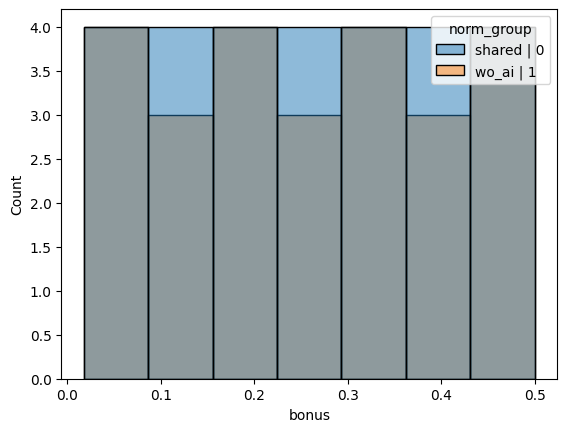

In [106]:
import seaborn as sns

df['norm_group'] = df['condition'] + " | " + df['generation'].astype(str)

sns.histplot(data=df, x='bonus', hue='norm_group', label='total_score_norm')

In [107]:
p_id_bonus = df.merge(subjects_df, left_on='_id', right_on='session_id')[['prolific_id', 'bonus']]
p_id_bonus.to_csv(f'../temp/bonus_{experiment_type}.csv', index=False)